In [ ]:
from datetime import date
print(date.today())

# Cell types and clustering

(working backwards from a mind map that I made)



At the end of the unit, students should be able to...

1. List some definitions of "cell type"
1. Explain what clustering is and why it makes sense for scRNA-seq.
1. How do we get from a cells $\times$ genes matrix to a clustering?
1. List ways of calculating cell-cell similarity
1. Explain their preference for one
1. Produce a cell type tree
1. Work with the CT tree to identify putative CT families

## 1. List some definitions of "cell type"

Possible references:
- Thomas Schwaha and his lecture
- [What is a cell type and how to define it?](https://doi.org/10.1016/j.cell.2022.06.031)
- [Cell types as species: exploring a metaphor](https://doi.org/10.3389/fpls.2022.868565)
- [The origin and evolution of cell types](https://doi.org/10.1038/nrg.2016.127)
- [What Is Your Conceptual Definition of ‘‘Cell Type’’ in the Context of a Mature Organism?](https://doi.org/10.1016/j.cels.2017.03.006)

Discuss morphological, electrophysiological, evolutionary, transcriptional, epigenetic, functional, developmental definitions.

When the data we have is transcriptomics measurements, what signals do we expect in the data?

## 2. Theory of clustering
### What is it and why does it make sense in the context of scRNA-seq?

> Task of grouping a set of objects in such a way that objects in the same group (cluster) are more similar, in some sense, to each other than to objects in other groups.

clustering is often used when we only have a vague or no idea of what to expect; if we knew what to expect it would be a classification problem instead. By clustering and then figuring out what each cluster is we break the problem down into a number of smaller problems.

Handing out smaller problems (iris dataset? Penguin dataset?) and explore the most common clustering strategies (k-means, DBSCAN, agglomerative?) or, even better, have the students come up with ideas about clustering! we could build our own clustering algorithm and then test it against the established ones.

UPDATE: these datasets are 2-d or 3-d at best. This may create skewed expectations about how things might work in scRNA-seq.

In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
penguins = pd.read_csv("../data/penguins.csv")
keep = ~np.any(penguins.isnull(), axis=1)
species = penguins["species"][keep]
data = penguins[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]]
data = data[keep].values

In [4]:
from scipy.spatial.distance import pdist, squareform

In [5]:
tmp = pdist(data, metric="euclidean")
eucl = squareform(tmp)

In [63]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [9]:
y_pred = KMeans(n_clusters=3, n_init="auto").fit_predict(data)

In [39]:
y_pred = AgglomerativeClustering(n_clusters=3).fit_predict(data)

In [81]:
y_pred = DBSCAN(min_samples=2, eps=0.1, metric="cosine").fit_predict(data)

<Axes: xlabel='bill_length_mm', ylabel='bill_depth_mm'>

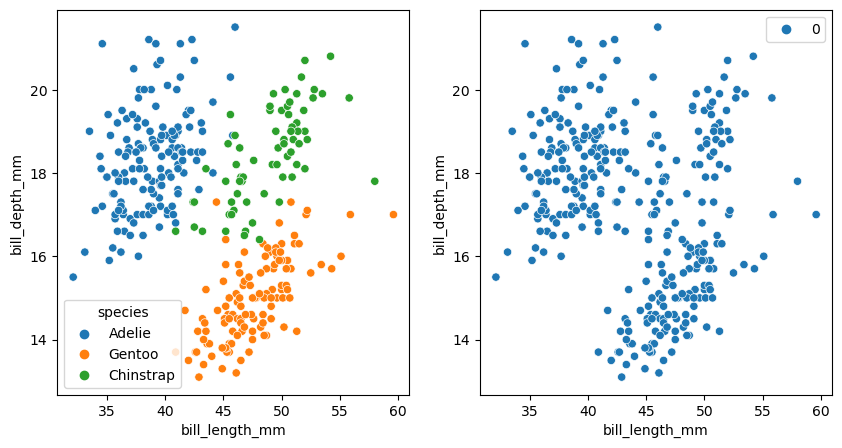

In [82]:
fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
sns.scatterplot(data=penguins[keep], x="bill_length_mm", y="bill_depth_mm", hue="species", ax=ax[0])
sns.scatterplot(data=penguins[keep], x="bill_length_mm", y="bill_depth_mm",
                hue=y_pred, ax=ax[1], palette="tab10")

In [41]:
penguin_species = np.unique(species)
clusters = np.unique(y_pred)
res = np.zeros((len(penguin_species), len(clusters)))

for i, s in enumerate(penguin_species):
    for j, c in enumerate(clusters):
        overlap = (species == s) & (y_pred == c)
        res[i][j] = np.sum(overlap)

res = pd.DataFrame(res, index=penguin_species, columns=clusters)

<Axes: >

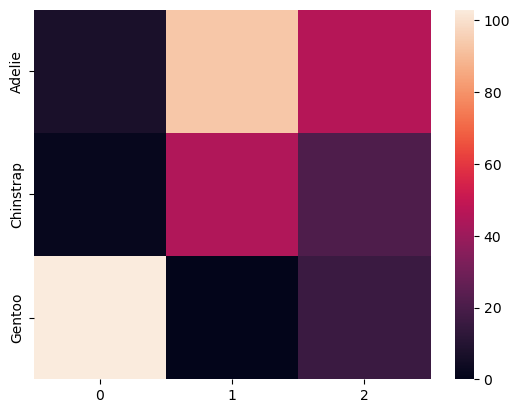

In [42]:
sns.heatmap(res)

## 3. Explore and perform clustering in the context of single-cell RNA-seq data

What algorithmic choices do we have for cluster detection? What are they good at? What are they bad at? (run sklearn tutorial; this will also help them practice plotting.)

How does that connect to the concepts/ideas that we have about cell types? What do we expect? How can we control for it?

Use gold standard datasets from [Kiselev _et al._](https://doi.org/10.1038/Nmeth.4236) to explore various clustering techniques and ideas. Stress negative controls! Introduce precision/recall curve, discuss trade-offs. Challenge students to search the literature.

Introduce actionable clustering concept; see [Valentin Svensson's blog post](https://www.nxn.se/valent/2018/3/5/actionable-scrna-seq-clusters) and [Jean Fang's blot post](http://jef.works/blog/2018/02/28/stability-testing/). Introduce [ROGUE](https://github.com/PaulingLiu/ROGUE) for cluster purity, [SC3](http://bioconductor.org/packages/release/bioc/html/SC3.html) for consensus clustering. Challenge them to find metrics that will get them a quantitative/qualitative agreement between different clustering approaches/different combinations of parameters per clustering function.

Speak about the dangers of overfitting.

In [83]:
import anndata as ad
import scanpy as sc

## 4. List ways of calculating cell-cell similarity, explain why this might be important

different metrics (cosine, euclidean, correlation, others), different feature subsets (all genes/HVG,  raw/normalised,  transformed, log1p/sqrt, etc.), different embeddings (PCA, CCA, LLE, diffusion maps, NMF, raw, spectral decomposition, UMAP, tSNE).

introduce them to the idea of negative tests! Why might UMAP/tSNE be misleading? Show circle examples, use simple datasets from visualisation paper.

## 5. Explain their preference for one

I want the students to develop an intuition for how distances work in single-cell land. I want them to understand that everything is a heuristic. I want them to get a feeling for how euclidean distances work in very high-dimensional spaces. Can we simulate data that suffers from high dimensionality and demonstrate that euclidean distances smother differences? How does that affect single-cell data?

## 6. Produce a cell type tree

Apply the evolutionary theory of cell types to cluster analysis. The theory predicts that a common mechanism for the evolution of cell types is duplication and subfunctionalisation. This implies a hierarchical structure, similar to how species are related in phylogenies. This means that a tree is a good (approximate) description of the relationships between cell types. If we pretend that every cluster that we have is a meaningful biological entity, how can we quantify, visualize, and examine the relationships between cell types/clusters? Go to the Spongilla dataset for that.

Introduce the concept of neighbour-joining. Ask about their tree experiences. Build different kinds of distance matrices. Speak about tree comparisons. Use the `ape` package in R to make NJ trees. Visualize them, including coloring the nodes. Scale the branch lengths to improve visualisation.

Try out PAGA, see how similar/different it is from the NJ tree. Can we combine?

## 7. Work with a CT tree to identify putative CT families

Explain which parts of the tree they trust and which not. Explain why they kept or excluded certain clusters. Use tree to define cell type families. Produce dotplot of CT family characteristic gene expression, combine with literature evidence.